In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
data_dir = '/kaggle/input/facebook-hateful-meme-dataset/data/'

img_path = data_dir + "data_dir"
train_path = data_dir + "train.jsonl"
dev_path = data_dir + "dev.jsonl"
test_path = data_dir + "test.jsonl"

In [2]:
import torch,json, os
from PIL import Image

class HatefulMemesDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
            
    def __getitem__(self, index: int):
        # Load images on the fly.
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        text = self.data[index]["text"]
        label = self.data[index]["label"]
        
        return image, text, label

    def load_image_only(self, index: int):
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        return image
    
    def get_label(self, index: int):
        label = self.data[index]["label"]
        return label
    
    def get_test_item(self, index: int):
        # Load images on the fly.
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        text = self.data[index]["text"]
        
        return image, text
    
    
    def __len__(self):
        return len(self.data)
train_data = HatefulMemesDataset(train_path)
val_data = HatefulMemesDataset(dev_path)
test_data = HatefulMemesDataset(test_path)

print('Data size of training data: %d samples' % len(train_data))
print('Data size of validation data: %d samples' % len(val_data))
print('Data size of test data: %d samples' % len(test_data))

Data size of training data: 8500 samples
Data size of validation data: 500 samples
Data size of test data: 1000 samples


There are 250 hateful memes among 500


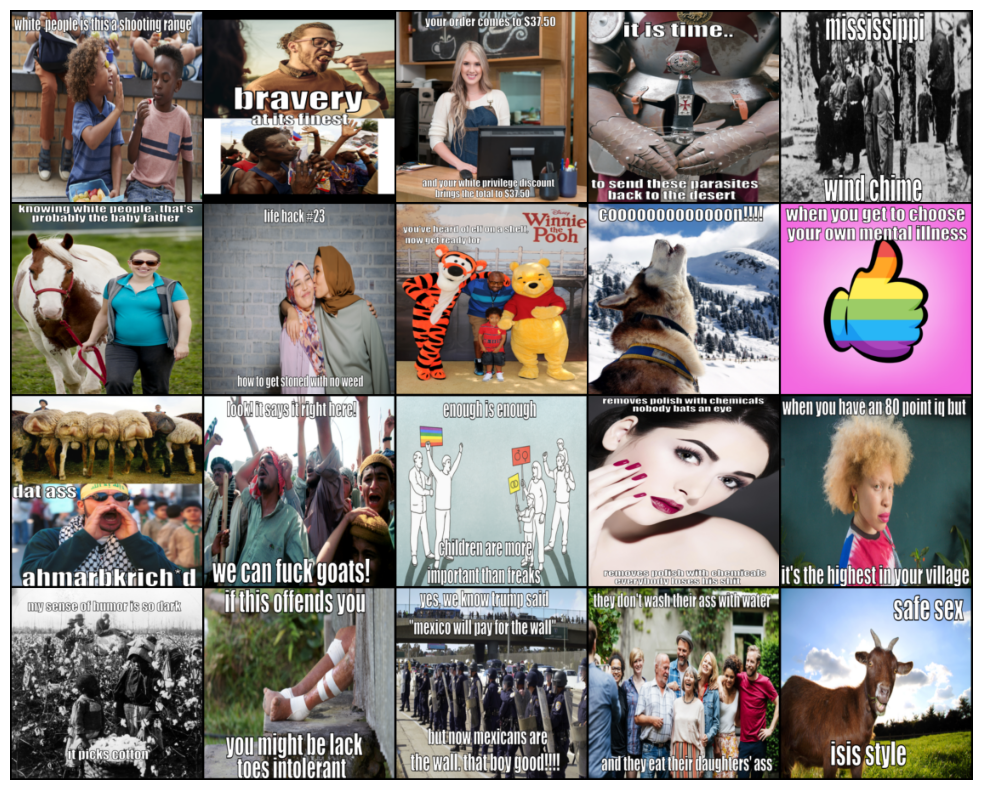

In [4]:
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

hateful_ids = [id for id in range(0, len(val_data)) 
             if val_data.get_label(id)==1]
print('There are %d hateful memes among %d' % (len(hateful_ids), len(val_data)))

def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 5)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));
    
show_image_group(val_data, hateful_ids, 20)

In [5]:
import numpy as np
import torch 
from tqdm.notebook import tqdm
from pkg_resources import packaging
from transformers import FlavaModel, FlavaFeatureExtractor, BertTokenizer

print("Torch version:", torch.__version__)

Torch version: 1.13.0


In [6]:
#这里创建flava模型
flava = FlavaModel.from_pretrained("facebook/flava-full").eval().to("cuda")
fe = FlavaFeatureExtractor.from_pretrained("facebook/flava-full")
tokenizer = BertTokenizer.from_pretrained("facebook/flava-full")

`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.


Some weights of the model checkpoint at facebook/flava-full were not used when initializing FlavaModel: ['image_codebook.blocks.group_1.group.block_2.res_path.path.conv_4.bias', 'image_codebook.blocks.group_2.group.block_1.res_path.path.conv_4.bias', 'image_codebook.blocks.group_3.group.block_1.res_path.path.conv_1.weight', 'image_codebook.blocks.group_3.group.block_1.id_path.bias', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_3.weight', 'mmm_image_head.bias', 'mim_head.transform.LayerNorm.weight', 'image_codebook.blocks.group_2.group.block_1.res_path.path.conv_2.bias', 'image_codebook.blocks.group_4.group.block_2.res_path.path.conv_4.weight', 'image_codebook.blocks.group_1.group.block_1.res_path.path.conv_2.weight', 'mim_head.transform.dense.weight', 'image_codebook.blocks.group_2.group.block_1.id_path.weight', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_1.bias', 'mmm_image_head.decoder.weight', 'image_codebook.blocks.group_3.group.block_2.res_pa

/opt/conda/lib/python3.7/site-packages/transformers/models/flava/feature_extraction_flava.py:31: FutureWarning: The class FlavaFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use FlavaImageProcessor instead.
  FutureWarning,


In [5]:
print(flava.modules)  #打印flava模型结构

<bound method Module.modules of FlavaModel(
  (text_model): FlavaTextModel(
    (embeddings): FlavaTextEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): FlavaEncoder(
      (layer): ModuleList(
        (0): FlavaLayer(
          (attention): FlavaAttention(
            (attention): FlavaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): FlavaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout):

In [7]:
flava = flava.cuda().eval()
input_resolution = flava.config.image_config.image_size
context_length = 77
vocab_size = flava.config.text_config.vocab_size

#打印出模型的参数数量
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in flava.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 241,356,289
Input resolution: 224
Context length: 77
Vocab size: 30522


In [9]:
original_images = []
images = []
texts = []
labels = []

for i in range(0,8):
    image, text, label  = val_data[i]
    original_images.append(image)
    images.append(fe(image))
    texts.append(text)
    labels.append(label)
image_input =  fe(original_images, return_tensors="pt").to("cuda")
text_tokens = tokenizer([desc for desc in texts], return_tensors="pt", padding=True, max_length=77).to("cuda")

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2365: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


In [10]:
with torch.no_grad():
    image_features = flava.get_image_features(**image_input)[:, 0].float()
    text_features = flava.get_text_features(**text_tokens)[:, 0].float()

/opt/conda/lib/python3.7/site-packages/transformers/modeling_utils.py:831: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


In [11]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

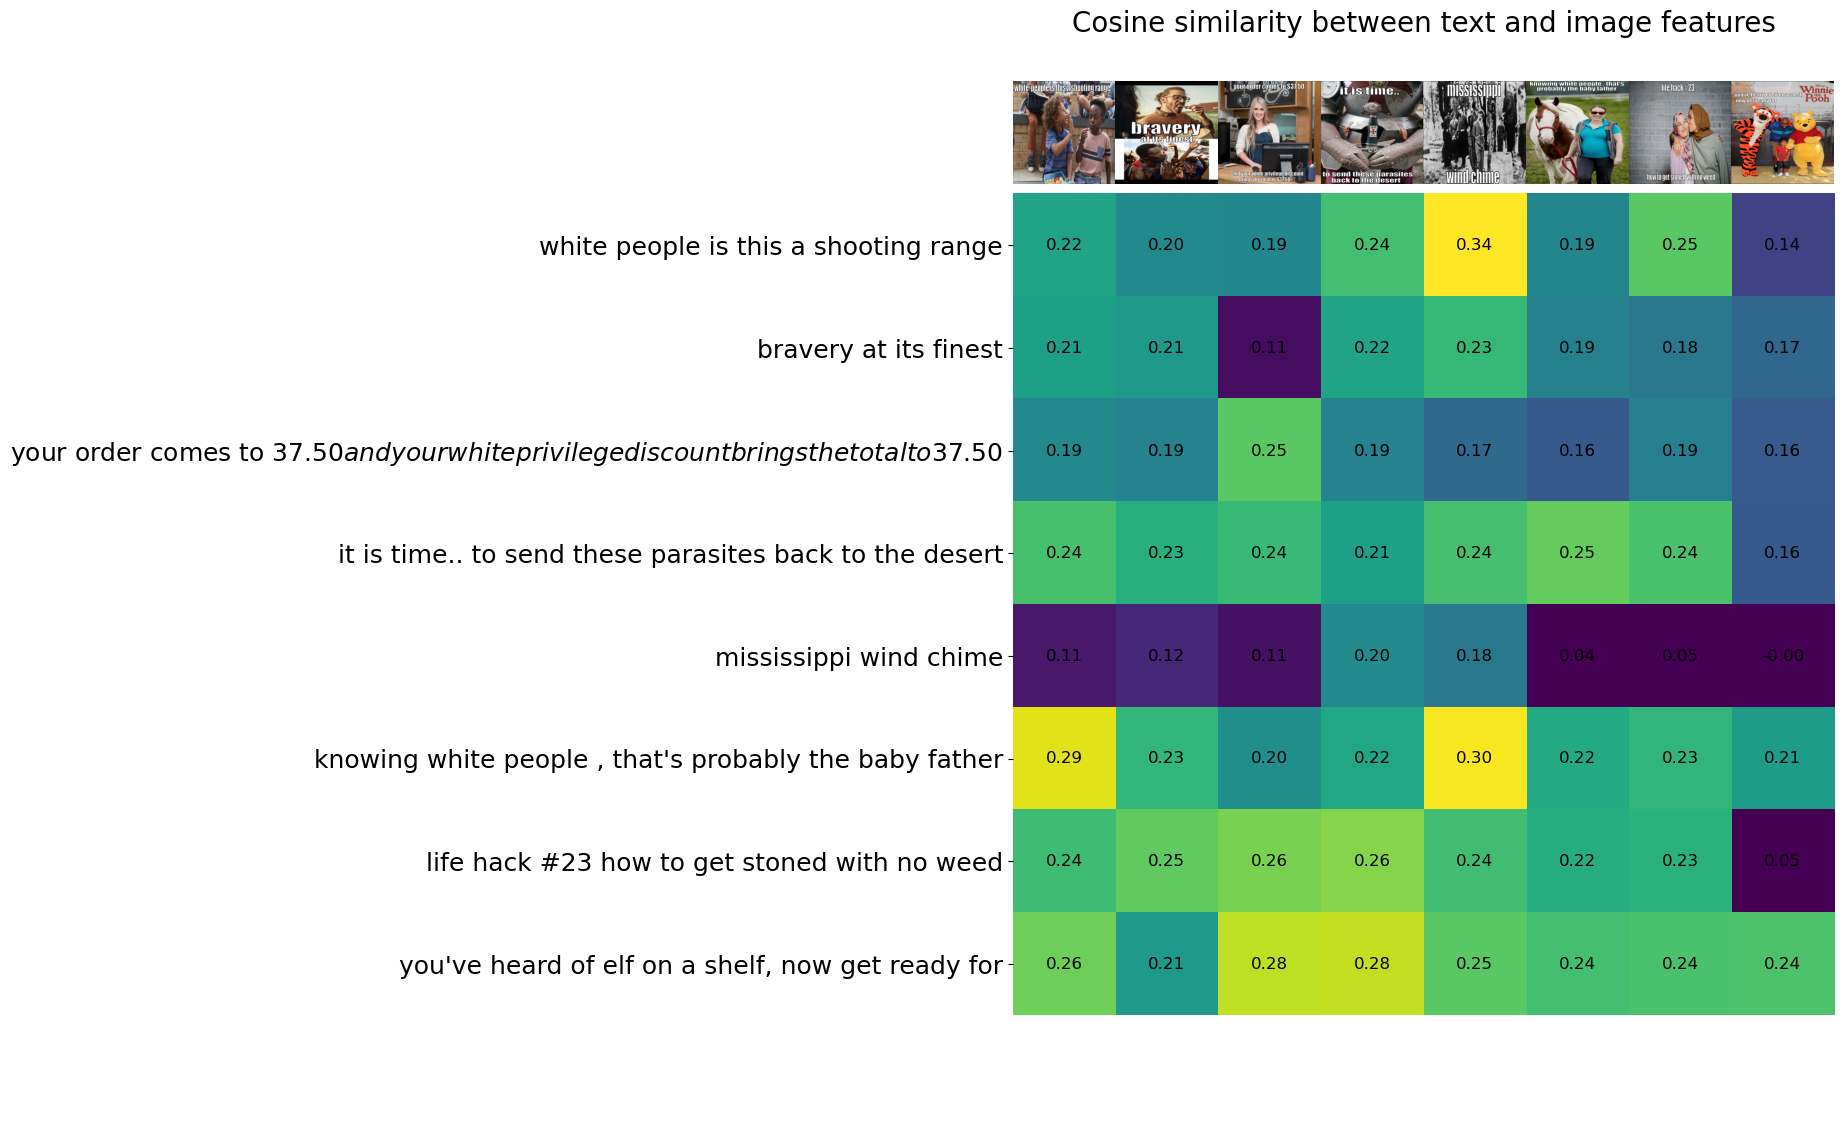

In [15]:
count = 8

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

**Zero-Shot Image Classification**

In [16]:
#Create text labels that act as classes for our dataset
descriptions = {
      'good meme': 'a nonhateful meme that is good',
      'hateful meme': 'a hateful meme containing racism, sexism, nationality, religion or disability'
}

In [21]:
#对flava模型进行分类测试
text_labels = [descriptions['good meme'],descriptions['hateful meme']]
text_tokens = tokenizer([desc for desc in text_labels], padding=True, max_length=77, return_tensors="pt").to("cuda")
with torch.no_grad():
    text_features = flava.get_text_features(**text_tokens)[:, 0, :].float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(2, dim=-1)

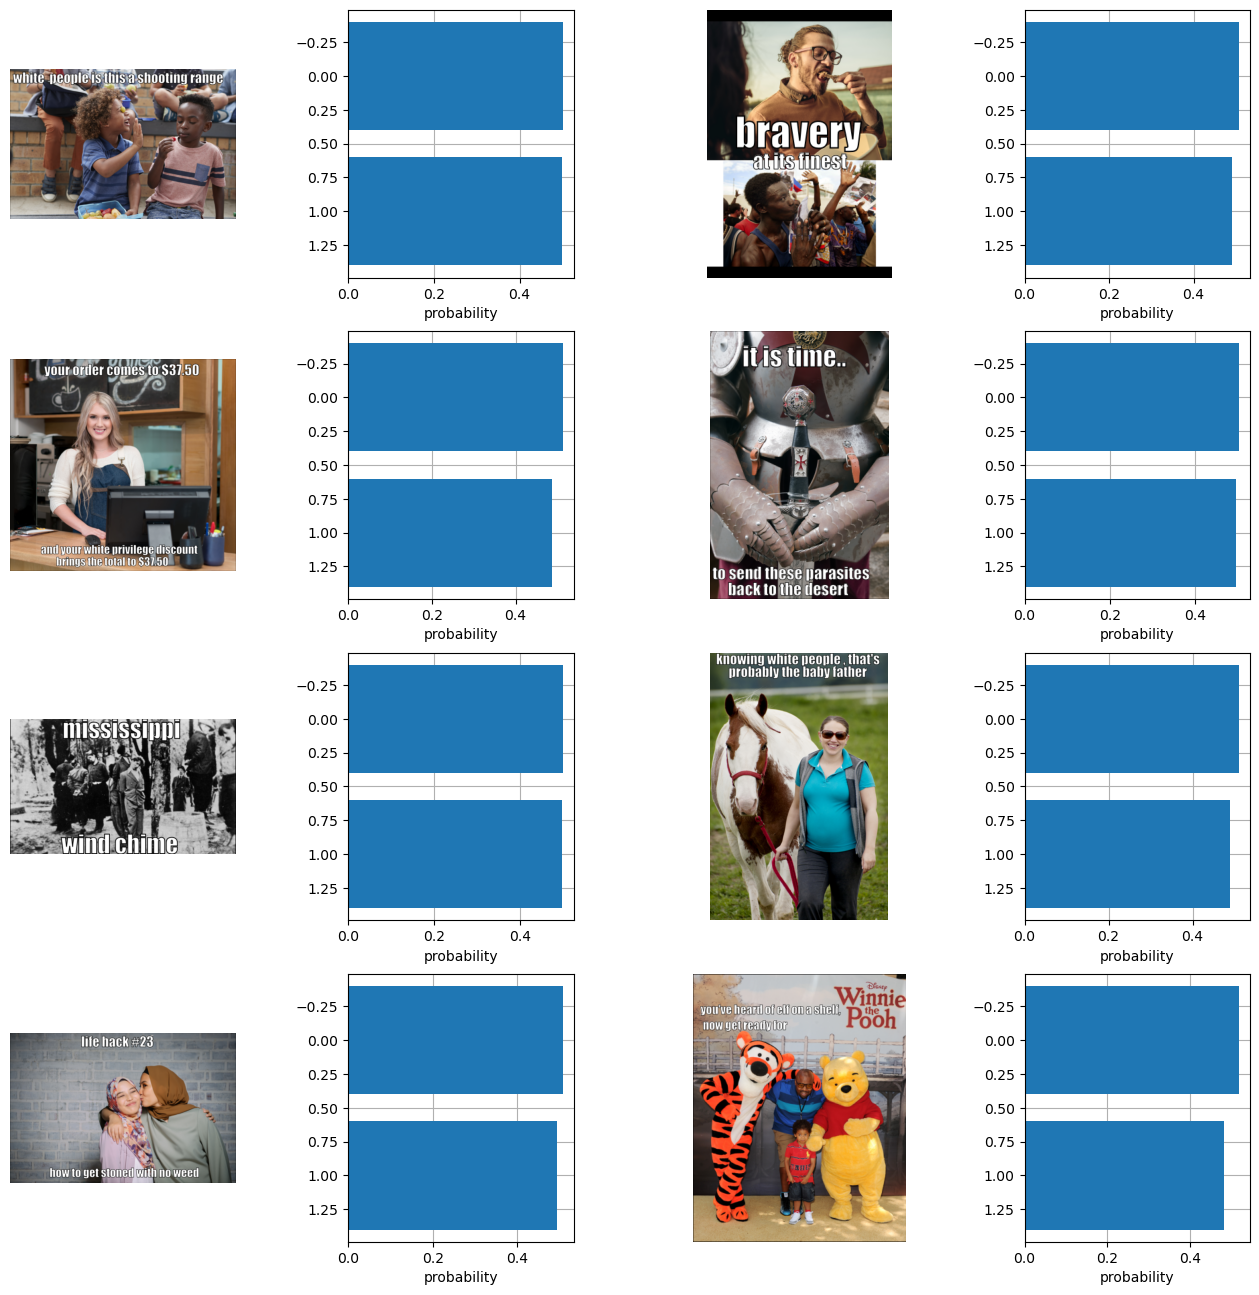

In [23]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()    